# In vivo recordings

#### **Basic instructions:**
#### 1. **To run code windows/blocks:** 

    - you can either hit the play button to the left of the code window 

    - or you can use they keyboard shortcut: select the block and press 'shift-enter'.

#### 2. **The first time** you run this code notebook, you might get a popup asking to choose which version of Python to use (the python "kernel"). **Just hit enter** to choose the base/default version.

#### 3. Make sure you data (.abf) files are in the "data" folder here on the left. You can just copy/paste the files from where they are saved on your computer.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
update_plot_defaults()
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Choose the data file you want to analyze

#### Put the .abf files with your Ih recordings in the "data/Dendrites" folder

In [9]:
data_folder = "data/13-In_vivo"

import os
print("Folders:")
for subdir in os.listdir(data_folder):
    if os.path.isdir(data_folder + "/" + subdir):
        print(f"'{data_folder}/{subdir}'")

from glob import glob
print("Files:")
data_files = glob(data_folder+"/*.h5")
data_files.sort()
data_files

Folders:
Files:


['data/13-In_vivo/eric_mp10_2025-06-18_0001.h5',
 'data/13-In_vivo/shannon_MP2_2025-06-17_0001.h5']

Choose which file you want to analyze (copy name from above) and paste the file name here:

In [10]:
data_file = 'data/13-In_vivo/shannon_MP2_2025-06-17_0001.h5'
# data_file = 'data/13-In_vivo/eric_mp10_2025-06-18_0001.h5'

Now we can load the file and plot the raw data:

Trace('shannon_MP2_2025-06-17_0001.h5')
Number of sweeps: 1
Points per sweep: 16,509,829
Duration per sweep: 825.491 s
Sampling rate: 20000 Hz
Sampling interval: 0.050 ms
Available channels: Current, Voltage


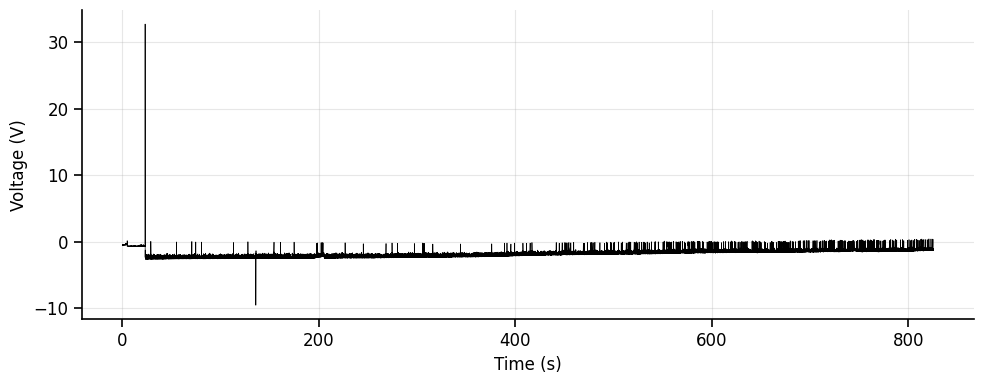

In [11]:
# Load with custom scaling and separate sweeps
traces = Trace.from_wavesurfer_h5_file(data_file, 
                                    current_scaling=1e-9,  # Convert to nA
                                    voltage_scaling=1e-3,   # Convert to mV
                                    concatenate_sweeps=False)
print(traces)

time_units = 's' # specify seconds (s), or milliseconds (ms)

# ----------------------------------------------------------------------------------------------------------------
ax = traces.plot(plot_voltage=True, plot_current=False, time_units=time_units, sweep='all')
plt.show()

## 2. Signal processing

### 2.1. Optional: apply highpass / lowpass / bandpass filtering

Depending in you recording, you may have 50/60 Hz line noise, high-frequency noise, or drift in your recordings.

The goal here is to only remove the noise with minimal distortion of the data, so be careful not to overdo it

In [12]:
apply_filtering = True

You can run this next cell as many times as you want to fine-tune the filtering parameters:

In [ ]:
window_size_ms = 1800
corrected_median, baseline_median = baseline_correction(traces.voltage_data, traces.sampling_rate, method='median_subtraction', window_ms=window_size_ms)

fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(baseline_median)
plt.show()



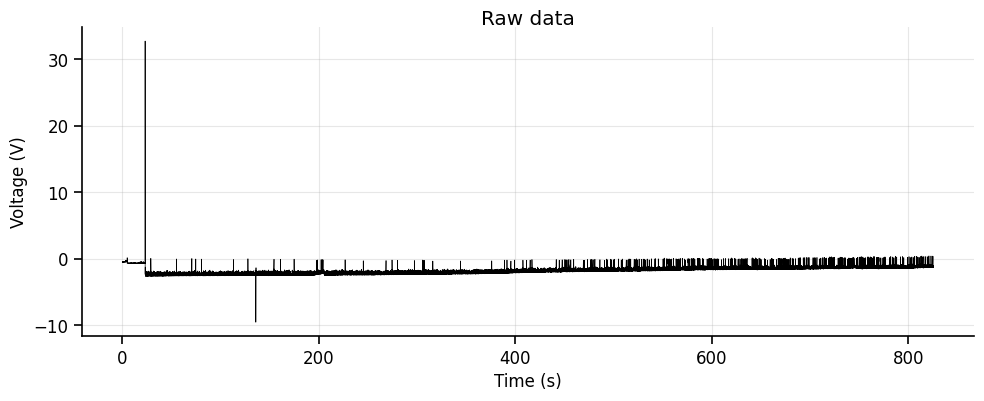

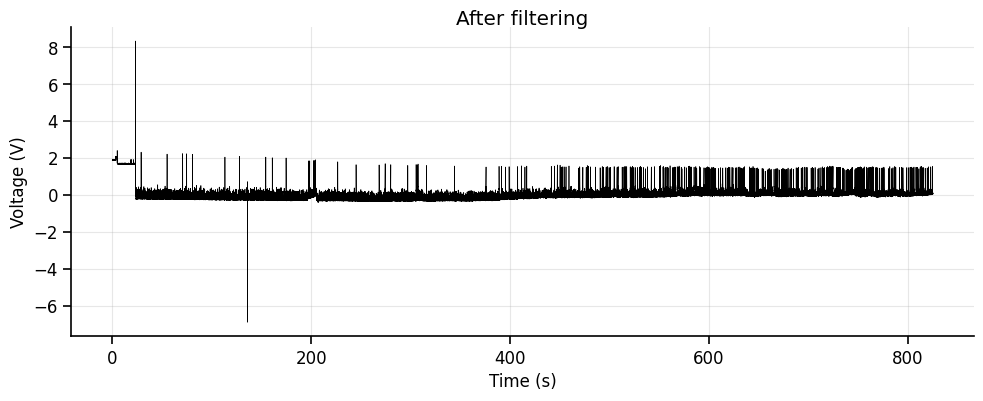

In [ ]:
if apply_filtering:
    filtered_traces = traces
    # Step 1: Detrend the data to remove linear or constant trends (e.g slow drift)
    filtered_traces = filtered_traces.detrend(detrend_type='linear', num_segments=1)

    # Step 2: Lowpass filter (removes high-frequency noise)
    filtered_traces = filtered_traces.lowpass_filter(cutoff_freq = 2000, # Choose a value in units of Hz
                                                     apply_to_voltage=True)
    
    # Step 3: Bandpass filter (removes 50/60 Hz mainline noise)
    filtered_traces = filtered_traces.filter_line_noise(
        line_freq = 60, # Frequency (Hz) of noise to remove: 50 Hz (in Europe) or 60 Hz (in the US).
        width = 0.5, # Width (Hz) controls the width of frequency bands around the line frequency the filter cuts out.
        method = 'notch', # Options: 'notch' (IIR notch filter), 'bandstop' (Butterworth), or 'fft' (spectral).
        apply_to_voltage=True)
    
    # # Step 4: Highpass filter (removes low-frequency oscillations)
    # # ------------------------------------------------------------
    # # # Be extra careful with this next one, it tends to distort the data. Use only in case of emergency.
    # filtered_traces = filtered_traces.highpass_filter(cutoff_freq=0.001)
    # # ------------------------------------------------------------

    %matplotlib inline
    ax = traces.plot(plot_voltage=True, plot_current=False)
    ax.set_title('Raw data', y=0.98)
    plt.show()

    ax = filtered_traces.plot(plot_voltage=True, plot_current=False)
    ax.set_title('After filtering', y=0.98)
    plt.show()


Once you are happy with the filter setting, run the next cell to implement them:

In [ ]:
if apply_filtering:
    traces=filtered_traces

### 2.2. Optional: apply baseline correction

If your baseline current is not at zero, run the next code blocks to apply a baseline correction.

In [ ]:
# Change this to True if you want to subtract the baseline from the sweeps.
subtract_baseline = True
start_baseline = 100
end_baseline = 230

In [ ]:
if subtract_baseline:
    traces.subtract_baseline(start_time = start_baseline, 
                             end_time = end_baseline , 
                             time_units = time_units,  # specify seconds (s), or milliseconds (ms)
                             channel = 'voltage')  # Options: 'current', 'voltage', 'all'
    %matplotlib inline
    ax1, ax2 = traces.plot(plot_voltage=True, plot_ttl=False, time_units=time_units, sweep='all', height_ratios=[1,4])
    ax1.set_title('After baseline subtraction', y=0.98)
    plt.show()
else:
    print("BASELINE NOT SUBTRACTED")


## 2. Measure Sag potential (caused by $I_{H}$ current)

### 2.1. Define the time window for the peak measurement

First we need to measure the peak voltage of the sag potential.

In [ ]:
# 1. Get the time of the negative current step
holding_current = traces.current_data[0,0]
step_start = traces.get_step_events(threshold=holding_current-5, channel='current', edge='rising', polarity='negative', time_units=time_units, sweep=0)
step_end = traces.get_step_events(threshold=holding_current-5, channel='current', edge='falling', polarity='negative', time_units=time_units, sweep=0)

step_start = step_start[0]
step_end = step_end[0]
print("Double check that these numbers look correct:")
print(f"Step start: {step_start} {time_units}")
print(f"Step end: {step_end} {time_units}")

#### The markers here will define where we will measure the steady-state potential:

In [ ]:
# The markers are important: the will define the window where we actually exctract peak current values from. Set them carefully.
marker_1 = step_end - 50
marker_2 = step_end - 2
sweeps_to_plot = [0,9] # Enter the range

# ----------------------------------------------------------------------------------------------------------------------
%matplotlib inline
ax1,ax2 = traces.plot(plot_voltage=True, time_units=time_units, marker_1=marker_1, marker_2=marker_2, sweep=sweeps_to_plot, height_ratios=[1,4])
ax1.set_xlim(step_start-10,step_end+10)
ax2.set_xlim(step_start-10,step_end+10)
plt.show()

#### Now we can measure the peak Sag and steady-state for each sweep

In [ ]:
# 1. Measure the Sag peak
measurement_type = 'peak' # Options: 'mean', 'max', 'min', 'peak'

_, peak_voltage = traces.get_measurements(start_time=step_start+5, end_time=step_end-5,
                                                    measurement_type=measurement_type, time_units=time_units)
if np.all(peak_voltage == peak_voltage[0]):
    print("WARNING: All voltage steps are the same")

# 2. Measure the steady state voltage
measurement_type = 'mean' # Options: 'mean', 'max', 'min', 'peak'

current_steps, ss_voltage = traces.get_measurements(start_time=marker_1, end_time=marker_2,
                                                    measurement_type=measurement_type, time_units=time_units)
if np.all(ss_voltage == ss_voltage[0]):
    print("WARNING: All voltage steps are the same")
if np.all(current_steps == current_steps[0]):
    print("WARNING: All current steps are the same")

# %matplotlib inline
# sweep_idx = range(0,9)
# current_steps = current_steps[sweep_idx]
# voltage_steps = voltage_steps[sweep_idx]
# ax = plot_IV(voltage_steps, current_steps)# ,xlabel_coords=(0.95,0.25),ylabel_coords=(0.35,0.6))
# ax.set_title(f'Sag peak voltage vs current step')
# plt.show()

In [ ]:
sag_size = np.abs(peak_voltage - ss_voltage)
sweeps_to_plot = range(1, 9)

sag_size = sag_size[sweeps_to_plot]
x_axis = current_steps[sweeps_to_plot]

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(x_axis, sag_size, marker='o', color='black')
ax.set_xlabel(f'Current step ({traces.current_unit})')
ax.set_ylabel(f"Sag size ({traces.voltage_unit})")
ax.set_title(f"Sag amplitude")
plt.show()


In [ ]:
sag_size = np.abs(peak_voltage - ss_voltage) / np.abs(ss_voltage)
sag_size = sag_size[sweeps_to_plot]

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(x_axis, sag_size, marker='o', color='black')
ax.axhline(1, color='grey', linestyle='--')  # y=0 across entire x-range
ax.set_xlabel(f'Current step ({traces.current_unit})')
ax.set_ylabel(f"Sag ratio \n(Sag ampl. / SS)")
ax.set_ylim(bottom=0)
plt.show()


## 3. Measure firing rate to get FI curve

In [ ]:
traces_during_stim = traces.crop(timepoint=step_start, timepoint_2=step_end, time_units=time_units)
spike_times, spike_properties = traces_during_stim.detect_spikes(threshold=0, time_units=time_units, return_properties=True, plot=True)

spike_counts = spike_properties['spike_counts']

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(current_steps, spike_counts, '-o', color='black')
ax.set_xlabel(f'Current step ({traces.current_unit})')
ax.set_ylabel('Spike count')
# ax.set_ylim(bottom=-1)
plt.show()

total_time_s = traces_during_stim.total_time
firing_rate = spike_counts / total_time_s
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(current_steps, firing_rate, '-o', color='black')
ax.set_xlabel(f'Current step ({traces.current_unit})')
ax.set_ylabel('Firing rate (Hz)')
# ax.set_ylim(bottom=-2)
plt.show()


In [ ]:
spike_max_height = spike_properties['heights']

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.hist(spike_max_height, bins=20, color='lightblue')
ax.set_xlabel('Spike height (mV)')
ax.set_ylabel('Count')
ax.set_title('Spike height distribution')
ax.axvline(np.mean(spike_max_height), color='r', linestyle='--')
ax.annotate('Avg. spike peak height: {:.2f} mV'.format(np.mean(spike_max_height)), xy=(0.02, 0.9), xycoords='axes fraction')
plt.show()